In [8]:
import pymongo as pm #import MongoClient only
from pymongo import MongoClient
import pprint # prettyprinting for json objects
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

#Database connexion
client = pm.MongoClient('bigdatadb.polito.it',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_collection = db['PermanentBookings'] # Collection for Car2go to use


# Step 2 -  Car sharing usage 

## Question 1

In [9]:
#Some practical implementations

# Collections
bookings_collection = db['PermanentBookings']
parkings_collection = db['PermanentParkings']

# Define date range for querying
start_date = datetime(2017, 11, 1)
end_date = datetime(2018, 1, 31, 23, 59, 59)

# Define the cities to analyze
cities = ["Madrid", "Denver", "Austin"]



### Code

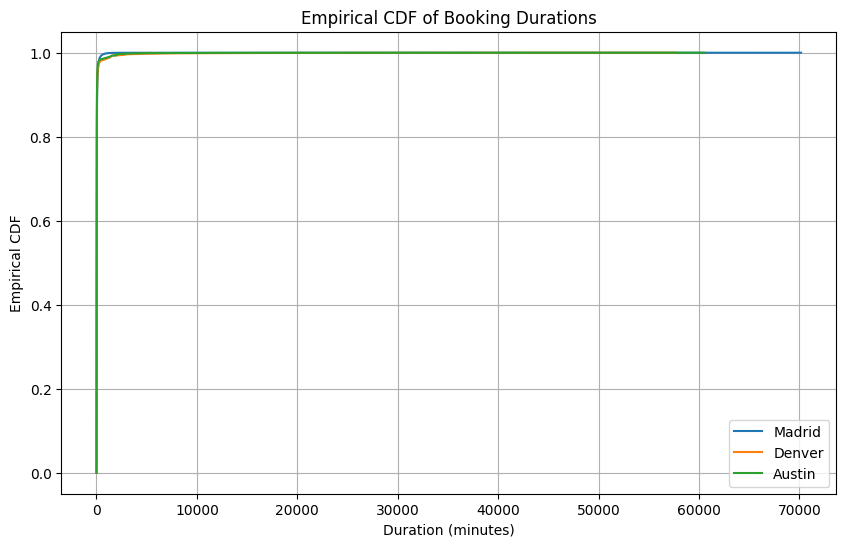

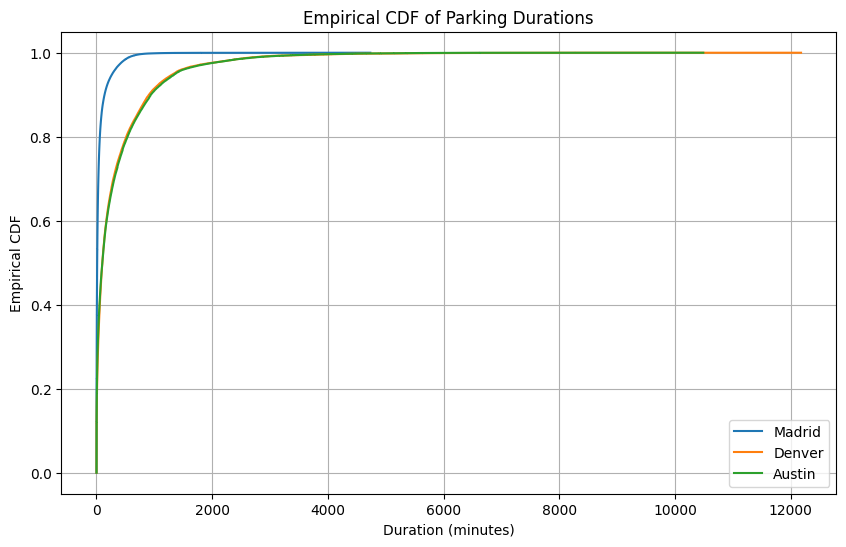

In [12]:
# Function to retrieve and process data for bookings or parkings
def get_durations(collection, city):
    # Query to filter by city and date range
    query = {
        'city': city,
        'init_date': {'$gte': start_date, '$lte': end_date},
        'final_date': {'$exists': True}  # Ensure final_date exists
    }
    # Fields to retrieve
    projection = {
        '_id': 0,
        'init_date': 1,
        'final_date': 1
    }
    # Retrieve data
    data = list(collection.find(query, projection))
    # Convert to DataFrame
    df = pd.DataFrame(data)
    # Ensure dates are datetime objects
    df['init_date'] = pd.to_datetime(df['init_date'])
    df['final_date'] = pd.to_datetime(df['final_date'])
    # Compute duration in minutes
    df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
    # Filter out any negative or zero durations (if any)
    df = df[df['duration'] > 0]
    return df['duration']

# Initialize dictionaries to hold durations
booking_durations = {}
parking_durations = {}

# Retrieve durations for each city
for city in cities:
    booking_durations[city] = get_durations(bookings_collection, city)
    parking_durations[city] = get_durations(parkings_collection, city)


def plot_cdf(durations_dict, title):
    plt.figure(figsize=(10, 6))
    for city, durations in durations_dict.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=city)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot CDFs for bookings
plot_cdf(booking_durations, 'Empirical CDF of Booking Durations')

# Plot CDFs for parkings
plot_cdf(parking_durations, 'Empirical CDF of Parking Durations')


### Interpretation

a. Density for Larger Values of Duration

Madrid’s CDF curve rises the quickest and reaches near 1.0 earlier than Denver and Austin, indicating that Madrid has a higher density of shorter parking durations.
Denver and Austin have slower-rising CDFs, which means they tend to have a greater density of larger parking durations compared to Madrid.
Of the three, Austin appears to have the slowest rise in the CDF in the mid-range (around 1000-5000 minutes), suggesting that it has a larger proportion of long-duration parkings.
Is This Expected?

This might be expected if there are city-specific factors influencing parking behavior. For instance, Madrid might have stricter rules or higher turnover in parking spots, encouraging shorter parking times.
Austin's slower rise in the CDF could indicate that users park for longer durations, which could be due to larger or more readily available parking spaces, or user patterns unique to that city.
Outliers:The tail extending to very high values of parking duration (above 8000 minutes) suggests the presence of outliers in the data.
These could represent vehicles left parked for abnormally long periods, possibly due to inactivity or service issues.
The CDFs reaching 1.0 with these extreme durations suggest that these values are rare, but they are still influencing the overall distribution.

b. Differences in the CDFs
Madrid’s Sharp Rise: Madrid’s CDF rises sharply at lower durations, indicating that most parkings are relatively short. This could reflect a high turnover rate, possibly driven by high demand or short-distance usage patterns.
Denver and Austin’s Gradual Increase:
Both Denver and Austin show slower increases in the CDF, particularly Austin. This suggests that a significant portion of parkings in these cities have longer durations.
These differences might be attributed to factors like urban layout, parking policies, and usage habits specific to each city.
Summary Interpretation
Madrid has shorter parking durations, likely due to higher turnover or restrictions.
Austin has the longest parking durations among the three, suggesting either more relaxed parking or different usage patterns.
Outliers in the form of extremely long parking durations exist in all cities and may require further investigation to understand if they represent actual usage or anomalies in the data.

## Question 2

### Code